# Backtesting basic trading strategies

In the world of trading, there are some basic strategies that are often considered too simplistic and are not recommended due to their widespread popularity. If these strategies were consistently profitable, they would be widely adopted, which would diminish their effectiveness. In this project, we aim to backtest different trading strategies over varying periods of 10, 15, and 20 years. To assess their performance, we will analyze the outcomes for the ten companies with the largest market capitalization during each selected timeframe.

## **Strategy 1**: Trading Based on Simple Moving Average (SMA)
The first strategy we explore revolves around the Simple Moving Average (SMA) indicator. This approach is straightforward: when the stock price is above the SMA, we will execute a buy order, and when it falls below the SMA, we will execute a sell order. To test the effectiveness of this strategy, we will consider different SMA timeframes, namely 10, 50, and 200 days. Below is a visualization depicting how Apple's stock price interacts with the SMA 200-day indicator.

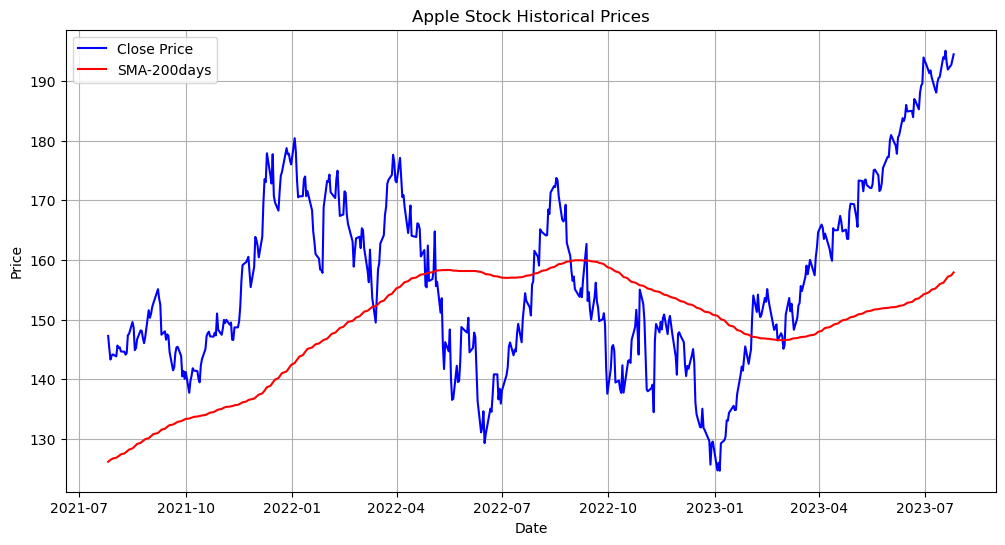

## Step 0. Importing necessary libraries and creating the portfolio

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

port_value = 100000
portfolio_2003 = ['GE','MSFT', 'PFE', 'XOM', 'WMT', 'C', 'BP', 'JNJ', 'AIG', 'IBM']
portfolio_2008 = ['XOM', '0857.HK', 'GE', 'MSFT', 'ICBC', '0941.HK', 'T', 'WMT', 'PG', 'CICHY']
portfolio_2013 = ['AAPL', 'XOM', 'MSFT', 'GOOGL', 'BRK-A', 'GE', 'WMT', 'WFC', 'JNJ', 'CVX']
amount_per_stock = port_value/len(portfolio_2013)

## Step 1. Defining essential functions

1. get_history: 
    - simple function to get historical data. Returns a DataFrame(df).
2. create_df: 
    - generates the Simple Moving Average(SMA) with different periods (10, 50 and 200 days).
    - creates new columns that indicate if the SMA is over or under the closing price, helping us decide if we should buy or sell based on this last condition.
    - calls erase_first_cell for all three SMAs.
    - returns the df.
3. erase_first_cell: 
    - if the first value that appears in the action column is "Sell", it replaces it with "Sell (First Val)".
4. buysell: 
    - decision-making function that processes the df. Returns the df with the daily value of the portfolio and tells us when it bought or sold and how many shares.
5. make_plot:
    - plots the results and compares them to just buying and holding.
6. my_main:
    - calls create_df and buysell to execute the core operations.

In [4]:
def get_history(ticker, period):
    '''
    Request stocks´ history through yfinance
    '''
    stock = yf.Ticker(ticker)
    return stock.history(period=f"{period}y")

def create_df(ticker, years):
    '''
    MASTER FUNCTION
    This function creates a data frame of the historical prices of the selected stock with the desired length.
    It erases irrelevant columns and creates new ones such as Simple Moving Average.
    The function will return a DataFrame with the following columns:
        ['Open', 'High', 'Low', 'Close', 'Volume',
        'SMA_10days','Trend_SMA_10days', 'Action_10days', 
        'SMA_50days', 'Trend_SMA_50days', 'Action_50days',
        'SMA_200days', 'Trend_SMA_200days', 'Action_200days']
    '''
    df = get_history(ticker,years)

    del df['Dividends']
    del df['Stock Splits']

    # Create SMA, and trend and buy/sell indicators
    # 10 days
    df['SMA_10days'] = df['Close'].rolling(window=10).mean()
    df['Trend_SMA_10days'] = np.where(df['SMA_10days'] > df['Close'], 'Bear', 'Bull')
    df['Action_10days'] = 'Same'
    df.loc[(df['Trend_SMA_10days'] == 'Bull') & (df['Trend_SMA_10days'].shift(1) == 'Bear'), 'Action_10days'] = 'Buy'
    df.loc[(df['Trend_SMA_10days'] == 'Bear') & (df['Trend_SMA_10days'].shift(1) == 'Bull'), 'Action_10days'] = 'Sell'
    erase_first_sell(df, 'Action_10days')
    # 50 days
    df['SMA_50days'] = df['Close'].rolling(window=50).mean()
    df['Trend_SMA_50days'] = np.where(df['SMA_50days'] > df['Close'], 'Bear', 'Bull')
    df['Action_50days'] = 'Same'
    df.loc[(df['Trend_SMA_50days'] == 'Bull') & (df['Trend_SMA_50days'].shift(1) == 'Bear'), 'Action_50days'] = 'Buy'
    df.loc[(df['Trend_SMA_50days'] == 'Bear') & (df['Trend_SMA_50days'].shift(1) == 'Bull'), 'Action_50days'] = 'Sell'
    erase_first_sell(df, 'Action_50days')
    # 200 days
    df['SMA_200days'] = df['Close'].rolling(window=200).mean()
    df['Trend_SMA_200days'] = np.where(df['SMA_200days'] > df['Close'], 'Bear', 'Bull')
    df['Action_200days'] = 'Same'
    df.loc[(df['Trend_SMA_200days'] == 'Bull') & (df['Trend_SMA_200days'].shift(1) == 'Bear'), 'Action_200days'] = 'Buy'
    df.loc[(df['Trend_SMA_200days'] == 'Bear') & (df['Trend_SMA_200days'].shift(1) == 'Bull'), 'Action_200days'] = 'Sell'
    erase_first_sell(df, 'Action_200days')

    return df

def erase_first_sell(df, action_name):
    '''
    If the first value that appears in SMA action is "Buy", nothing will happen
    However, if the first value that appears in SMA is "Sell", it will be replaced with "Sell (First Val)"
    This will help the buy/sell decision making. 
    We cannot sell our shares if we didnt buy them in the first place.
    Our model is oversimplified so more complex operations like "shorting" will not take place.
    
    '''
    buy_encountered = False
    for date, row in df.iterrows():
        if row[action_name] == "Buy":
            buy_encountered = True
        elif row[action_name] == "Sell" and not buy_encountered:
            df.at[date, action_name] = "Sell (First Val)"
            break
            
def buysell(df, sma, cash=10000 ):
    '''
    Decision making on when to buy/sell. always the same amount is bought/sold {cash}. 
    Two new columns will be created: Total_Value with the value of the portfolio (doesn´t include other stocks)
    and Events with a daily report that tells us if the function sold or bought any shares.
    Returns the df
    '''
    #Will use the open so the buy/sell happens in the same day.
    moving_average = f"SMA_{sma}days"
    action = f"Action_{sma}days"
    shares = 0
    events = []
    holding = False
    # Creating new column
    df['Total_Value'] = ''
    for date, row in df.iterrows():
        price = row['Close']
        if row[action] == "Buy":
            #Buying
            act = "Bought"
            shares = cash/price #Quantity of shares
            cash = 0
            holding = True
            events.append(f"BOUGHT {shares} shares at ${price}. Total portfolio value: {cash+(shares*price)}")
        elif row[action] == "Sell":
            # Selling
            act = "Sold"
            cash = shares*price
            holding = False
            events.append(f"SOLD {shares} shares at ${price}. Total portfolio value: {cash+(shares*price)}")
            shares = 0
        elif holding == True:
            events.append(f"HOLDING {shares} shares at ${price}. Total portfolio value: {cash+(shares*price)}")
        elif holding == False:
            events.append(f"NOT HOLDING. Total portfolio value: {cash+(shares*price)}")
            
            
        df.loc[date, 'Total_Value'] = cash+(shares*price)
        #row['Total_Value'] = cash+(shares*price)
        #print(cash+(shares*price))
        #print(events)
    df['Events'] = events 
    return df


def make_plot(ticker, df, sma):
    '''
    Gets the full name of the company. Set starting value of both Close and Total_value at 100 so it is easier to compare.
    Indicates the final value
    Returns the results
    '''
    df = df.copy()
    # Ticker --> Company name
    try:
        company_name = yf.Ticker(ticker).info['longName']
        
    except Exception as e:
        company_name = ''
        
    # Set the starting values for both columns to 100
    df['Total_Value'] = (df['Total_Value']/df['Total_Value'][0])*100
    df['Close'] = (df['Close']/df['Close'][0])*100


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Total_Value'], label='SMA trading strategy')
    plt.plot(df['Close'], label='Buy and hold')
    plt.title(f'{company_name}: SMA {sma} days trading vs buying and holding', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Value (Starting from 100)', fontsize=14)
    plt.grid(True)
    plt.legend()
    
    final_total_value = df['Total_Value'].iloc[-1]
    final_close = df['Close'].iloc[-1]
    plt.text(df.index[-1], final_total_value, f'Final Total Value: {final_total_value:.2f}', ha='right', va='bottom', fontsize=12)
    plt.text(df.index[-1], final_close, f'Final Close: {final_close:.2f}', ha='right', va='bottom', fontsize=12)

    
    return plt.gcf()

def my_main(ticker, years, sma_period):
    '''
    Calls create_df and buysell.
    Returns df
    '''
    company = create_df(ticker, years)
    company = buysell(company, sma_period)
    return company

### Example: SMA 10-Day trading strategy 2013-2023 on Apple
During the period from 2013 to 2023, the SMA 10-Day strategy yielded a profit of 330%.
However, a simple buy and hold approach would have generated three times more profit.
Let's investigate how this strategy performs on various other stocks.


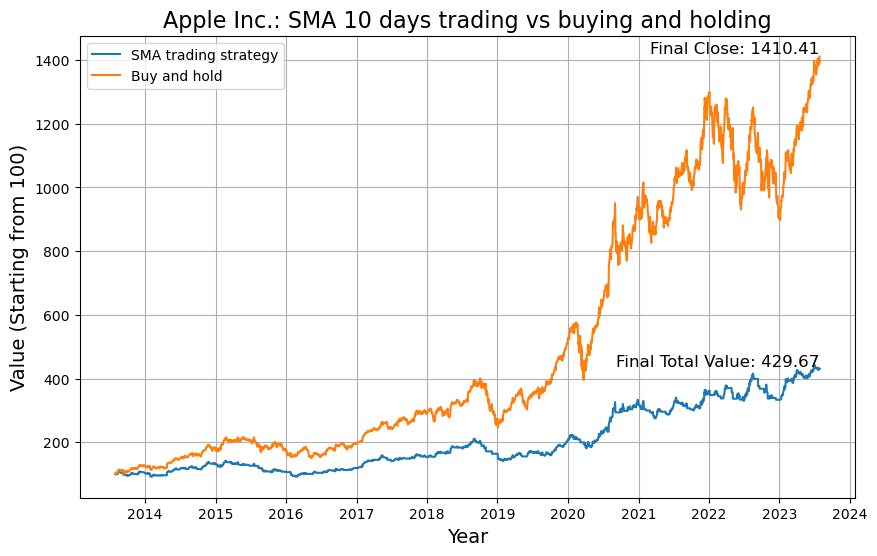

In [6]:
example = create_df('AAPL', 10)
example = buysell(example, 10)
plot = make_plot('AAPL', example, 10)

## Step 2. Setting up DataFrames for each stock in the 2013 portfolio

Here, we basically repeat on every ticker what we previously did, generating a new DataFrame and doing the decision-making for each stock. The results are appended to a master DataFrame.

In [7]:
# Portfolio_2013 10 years analysis SMA: 10
years = 10
sma_period = 10
aapl = my_main(portfolio_2013[0], years, sma_period)
xom = my_main(portfolio_2013[1], years, sma_period)
msft = my_main(portfolio_2013[2], years, sma_period)
googl = my_main(portfolio_2013[3], years, sma_period)
brka = my_main(portfolio_2013[4], years, sma_period)
ge = my_main(portfolio_2013[5], years, sma_period)
wmt = my_main(portfolio_2013[6], years, sma_period)
wfc = my_main(portfolio_2013[7], years, sma_period)
jnj = my_main(portfolio_2013[8], years, sma_period)
cvx = my_main(portfolio_2013[9], years, sma_period)

print("Done!")

Done!


In [8]:
# Creating a dict so I can iterate instead of writing the same code 10 times
stock_dict = {
    'AAPL': aapl,
    'XOM': xom,
    'MSFT': msft,
    'GOOGL': googl,
    'BRK-A': brka,
    'GE': ge,
    'WMT': wmt,
    'WFC': wfc,
    'JNJ': jnj,
    'CVX': cvx,
}
# We will apend these values to the master df
all_close = []
all_totvals = []

for name, df in stock_dict.items():
    all_close.append((df['Close']/df['Close'][0])*100)
    all_totvals.append(df['Total_Value'])
# Creating a master df with every 'Total_Value' and every 'Close'
# Total_Value
all_2013_stocks = pd.concat(all_totvals, axis=1)
column_names_total_value = ['Total_Value_' + stock_name for stock_name in stock_dict.keys()]
all_2013_stocks.columns = column_names_total_value

# Concatenate 'Close' columns from all DataFrames
all_close_df = pd.concat(all_close, axis=1)
column_names_close = ['Close_' + stock_name for stock_name in stock_dict.keys()]
all_close_df.columns = column_names_close

# Combine both 'Total_Value' and 'Close' columns into the final DataFrame 'all_2013_stocks'
all_2013_stocks = pd.concat([all_2013_stocks, all_close_df], axis=1)    

In [87]:
all_2013_stocks

,Total_Value_AAPL,Total_Value_XOM,Total_Value_MSFT,Total_Value_GOOGL,Total_Value_BRK-A,Total_Value_GE,Total_Value_WMT,Total_Value_WFC,Total_Value_JNJ,Total_Value_CVX,...,Close_MSFT,Close_GOOGL,Close_BRK-A,Close_GE,Close_WMT,Close_WFC,Close_JNJ,Close_CVX,Sum_Total_Value,Sum_Close
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-29 00:00:00-04:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100000.000000,1000.000000
2013-07-30 00:00:00-04:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,100.982892,100.980427,99.461907,99.959177,99.871744,100.023107,99.957092,99.690882,100000.000000,1001.928193
2013-07-31 00:00:00-04:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,100.951193,100.621122,99.653305,99.509990,99.935866,100.578017,100.311123,99.778055,100000.000000,1002.099409
2013-08-01 00:00:00-04:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,100.412170,102.487900,100.684794,100.530839,100.294922,102.335281,100.600781,100.214004,100000.000000,1008.163430
2013-08-02 00:00:00-04:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,101.109723,102.754261,101.143234,100.857482,100.974490,102.867072,101.265956,99.033016,100000.000000,1011.087119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24 00:00:00-04:00,42862.445586,12519.229945,17753.691722,8453.668157,18039.19649,25305.574607,11564.789982,10644.12537,13596.158368,23518.42078,...,1313.065492,550.436800,305.233088,91.064290,253.882219,142.877788,240.778526,194.483081,184257.301006,4651.959328
2023-07-25 00:00:00-04:00,43055.909235,12538.213291,17753.691722,8453.668157,17897.157973,25305.574607,11555.351946,10428.583284,13700.267171,23625.968678,...,1335.399613,553.516675,302.829718,96.771814,253.675025,139.984532,242.622220,195.372437,184314.386064,4686.836638
2023-07-26 00:00:00-04:00,43251.598788,12468.213333,17085.486552,8453.668157,18013.897784,24778.554619,11596.733081,10648.711483,13726.493247,23448.657464,...,1285.138465,585.493032,304.805020,94.756421,254.583467,142.939348,243.086666,193.906181,183472.014508,4676.749937


###### This DataFrame is exactly what we need. 

In [10]:
# Sum the 'Total_Value' columns
all_2013_stocks['Sum_Total_Value'] = all_2013_stocks.filter(like='Total_Value').sum(axis=1)

# Sum the 'Close' columns
all_2013_stocks['Sum_Close'] = all_2013_stocks.filter(like='Close').sum(axis=1)

# Step 3. Graph the overall portfolio performance and compare the 2 strategies
We make a simple function to plot our results for both the buy and hold strategy and the SMA 10-day strategy. 

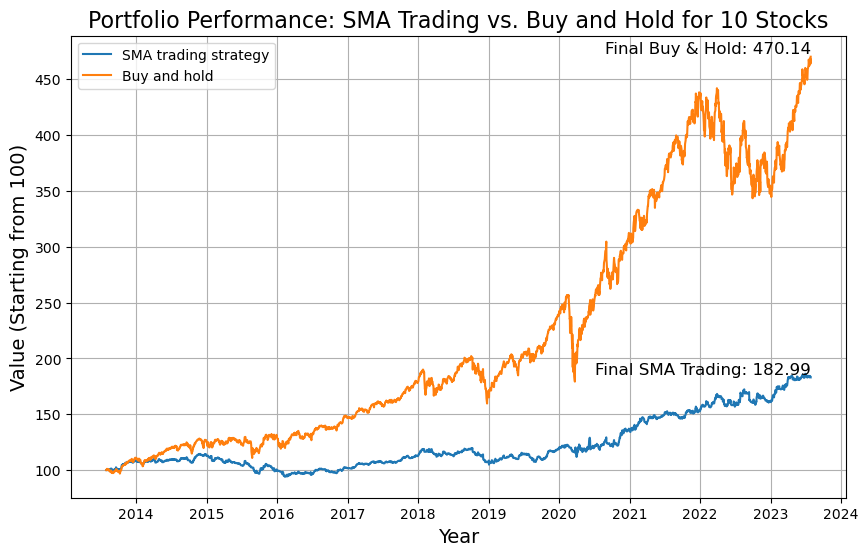

<module 'matplotlib.pyplot' from 'C:\\Users\\loren\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
def make_portfolio_plot(df):
    '''
    Graphs and compares the performance of the entire portfolio
    '''
    df = df.copy()
    
        
    # Set the starting values for both columns to 100
    df['Sum_Total_Value'] = (df['Sum_Total_Value']/df['Sum_Total_Value'][0])*100
    df['Sum_Close'] = (df['Sum_Close']/df['Sum_Close'][0])*100


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Sum_Total_Value'], label='SMA trading strategy')
    plt.plot(df['Sum_Close'], label='Buy and hold')
    plt.title("Portfolio Performance: SMA Trading vs. Buy and Hold for 10 Stocks", fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Value (Starting from 100)', fontsize=14)
    plt.grid(True)
    plt.legend()
    
    final_total_value = df['Sum_Total_Value'].iloc[-1]
    final_close = df['Sum_Close'].iloc[-1]
    plt.text(df.index[-1], final_total_value, f'Final SMA Trading: {final_total_value:.2f}', ha='right', va='bottom', fontsize=12)
    plt.text(df.index[-1], final_close, f'Final Buy & Hold: {final_close:.2f}', ha='right', va='bottom', fontsize=12)
    plt.show()
    return plt
make_portfolio_plot(all_2013_stocks)

##### We can see SMA is significantly worse than just buying and holding
Now we do the same for 50 and 200 days. Get ready, it´s going to take a lot of code (or just skip until the next comment).

In [13]:
# Portfolio_2013 10 years analysis SMA: 10 days
years = 10
sma_period = 50
#def dif_sma(years, sma_period):
aapl = my_main(portfolio_2013[0], years, sma_period)
xom = my_main(portfolio_2013[1], years, sma_period)
msft = my_main(portfolio_2013[2], years, sma_period)
googl = my_main(portfolio_2013[3], years, sma_period)
brka = my_main(portfolio_2013[4], years, sma_period)
ge = my_main(portfolio_2013[5], years, sma_period)
wmt = my_main(portfolio_2013[6], years, sma_period)
wfc = my_main(portfolio_2013[7], years, sma_period)
jnj = my_main(portfolio_2013[8], years, sma_period)
cvx = my_main(portfolio_2013[9], years, sma_period)

print("Done!")

    # Creating a dict so I can iterate instead of writing the same code 10 times
stock_dict = {
    'AAPL': aapl,
    'XOM': xom,
    'MSFT': msft,
    'GOOGL': googl,
    'BRK-A': brka,
    'GE': ge,
    'WMT': wmt,
    'WFC': wfc,
    'JNJ': jnj,
    'CVX': cvx,
}
# We will apend these values to the master df
all_close = []
all_totvals = []

for name, df in stock_dict.items():
    all_close.append((df['Close']/df['Close'][0])*100)
    all_totvals.append(df['Total_Value'])
# Creating a master df with every 'Total_Value' and every 'Close'
# Total_Value
all_2013_stocks_50 = pd.concat(all_totvals, axis=1)
column_names_total_value = ['Total_Value_' + stock_name for stock_name in stock_dict.keys()]
all_2013_stocks_50.columns = column_names_total_value

# Concatenate 'Close' columns from all DataFrames
all_close_df = pd.concat(all_close, axis=1)
column_names_close = ['Close_' + stock_name for stock_name in stock_dict.keys()]
all_close_df.columns = column_names_close

# Combine both 'Total_Value' and 'Close' columns into the final DataFrame 'all_2013_stocks'
all_2013_stocks_50 = pd.concat([all_2013_stocks_50, all_close_df], axis=1) 

# Sum the 'Total_Value' columns
all_2013_stocks_50['Sum_Total_Value'] = all_2013_stocks_50.filter(like='Total_Value').sum(axis=1)

# Sum the 'Close' columns
all_2013_stocks_50['Sum_Close'] = all_2013_stocks_50.filter(like='Close').sum(axis=1)
'''
def make_portfolio_plot(df):
    
    df = df.copy()


    # Set the starting values for both columns to 100
    df['Sum_Total_Value'] = (df['Sum_Total_Value']/df['Sum_Total_Value'][0])*100
    df['Sum_Close'] = (df['Sum_Close']/df['Sum_Close'][0])*100


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Sum_Total_Value'], label='SMA trading strategy')
    plt.plot(df['Sum_Close'], label='Buy and hold')
    plt.title("Portfolio Performance: SMA Trading vs. Buy and Hold for 10 Stocks", fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Value (Starting from 100)', fontsize=14)
    plt.grid(True)
    plt.legend()

    final_total_value = df['Sum_Total_Value'].iloc[-1]
    final_close = df['Sum_Close'].iloc[-1]
    plt.text(df.index[-1], final_total_value, f'Final SMA Trading: {final_total_value:.2f}', ha='right', va='bottom', fontsize=12)
    plt.text(df.index[-1], final_close, f'Final Buy & Hold: {final_close:.2f}', ha='right', va='bottom', fontsize=12)
    plt.show()
    return plt
'''

#make_portfolio_plot(all_2013_stocks)

Done!


'\ndef make_portfolio_plot(df):\n    \n    df = df.copy()\n\n\n    # Set the starting values for both columns to 100\n    df[\'Sum_Total_Value\'] = (df[\'Sum_Total_Value\']/df[\'Sum_Total_Value\'][0])*100\n    df[\'Sum_Close\'] = (df[\'Sum_Close\']/df[\'Sum_Close\'][0])*100\n\n\n    # Create the plot\n    plt.figure(figsize=(10, 6))\n    plt.plot(df[\'Sum_Total_Value\'], label=\'SMA trading strategy\')\n    plt.plot(df[\'Sum_Close\'], label=\'Buy and hold\')\n    plt.title("Portfolio Performance: SMA Trading vs. Buy and Hold for 10 Stocks", fontsize=16)\n    plt.xlabel(\'Year\', fontsize=14)\n    plt.ylabel(\'Value (Starting from 100)\', fontsize=14)\n    plt.grid(True)\n    plt.legend()\n\n    final_total_value = df[\'Sum_Total_Value\'].iloc[-1]\n    final_close = df[\'Sum_Close\'].iloc[-1]\n    plt.text(df.index[-1], final_total_value, f\'Final SMA Trading: {final_total_value:.2f}\', ha=\'right\', va=\'bottom\', fontsize=12)\n    plt.text(df.index[-1], final_close, f\'Final Buy & Hol

In [14]:
# Portfolio_2013 10 years analysis SMA: 10 days
years = 10
sma_period = 200
#def dif_sma(years, sma_period):
aapl = my_main(portfolio_2013[0], years, sma_period)
xom = my_main(portfolio_2013[1], years, sma_period)
msft = my_main(portfolio_2013[2], years, sma_period)
googl = my_main(portfolio_2013[3], years, sma_period)
brka = my_main(portfolio_2013[4], years, sma_period)
ge = my_main(portfolio_2013[5], years, sma_period)
wmt = my_main(portfolio_2013[6], years, sma_period)
wfc = my_main(portfolio_2013[7], years, sma_period)
jnj = my_main(portfolio_2013[8], years, sma_period)
cvx = my_main(portfolio_2013[9], years, sma_period)

print("Done!")

    # Creating a dict so I can iterate instead of writing the same code 10 times
stock_dict = {
    'AAPL': aapl,
    'XOM': xom,
    'MSFT': msft,
    'GOOGL': googl,
    'BRK-A': brka,
    'GE': ge,
    'WMT': wmt,
    'WFC': wfc,
    'JNJ': jnj,
    'CVX': cvx,
}
# We will apend these values to the master df
all_close = []
all_totvals = []

for name, df in stock_dict.items():
    all_close.append((df['Close']/df['Close'][0])*100)
    all_totvals.append(df['Total_Value'])
# Creating a master df with every 'Total_Value' and every 'Close'
# Total_Value
all_2013_stocks_200 = pd.concat(all_totvals, axis=1)
column_names_total_value = ['Total_Value_' + stock_name for stock_name in stock_dict.keys()]
all_2013_stocks_200.columns = column_names_total_value

# Concatenate 'Close' columns from all DataFrames
all_close_df = pd.concat(all_close, axis=1)
column_names_close = ['Close_' + stock_name for stock_name in stock_dict.keys()]
all_close_df.columns = column_names_close

# Combine both 'Total_Value' and 'Close' columns into the final DataFrame 'all_2013_stocks'
all_2013_stocks_200 = pd.concat([all_2013_stocks_200, all_close_df], axis=1) 

# Sum the 'Total_Value' columns
all_2013_stocks_200['Sum_Total_Value'] = all_2013_stocks_200.filter(like='Total_Value').sum(axis=1)

# Sum the 'Close' columns
all_2013_stocks_200['Sum_Close'] = all_2013_stocks_200.filter(like='Close').sum(axis=1)
'''
def make_portfolio_plot(df):
    
    df = df.copy()


    # Set the starting values for both columns to 100
    df['Sum_Total_Value'] = (df['Sum_Total_Value']/df['Sum_Total_Value'][0])*100
    df['Sum_Close'] = (df['Sum_Close']/df['Sum_Close'][0])*100


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Sum_Total_Value'], label='SMA trading strategy')
    plt.plot(df['Sum_Close'], label='Buy and hold')
    plt.title("Portfolio Performance: SMA Trading vs. Buy and Hold for 10 Stocks", fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Value (Starting from 100)', fontsize=14)
    plt.grid(True)
    plt.legend()

    final_total_value = df['Sum_Total_Value'].iloc[-1]
    final_close = df['Sum_Close'].iloc[-1]
    plt.text(df.index[-1], final_total_value, f'Final SMA Trading: {final_total_value:.2f}', ha='right', va='bottom', fontsize=12)
    plt.text(df.index[-1], final_close, f'Final Buy & Hold: {final_close:.2f}', ha='right', va='bottom', fontsize=12)
    plt.show()
    return plt
'''

#make_portfolio_plot(all_2013_stocks)

Done!


'\ndef make_portfolio_plot(df):\n    \n    df = df.copy()\n\n\n    # Set the starting values for both columns to 100\n    df[\'Sum_Total_Value\'] = (df[\'Sum_Total_Value\']/df[\'Sum_Total_Value\'][0])*100\n    df[\'Sum_Close\'] = (df[\'Sum_Close\']/df[\'Sum_Close\'][0])*100\n\n\n    # Create the plot\n    plt.figure(figsize=(10, 6))\n    plt.plot(df[\'Sum_Total_Value\'], label=\'SMA trading strategy\')\n    plt.plot(df[\'Sum_Close\'], label=\'Buy and hold\')\n    plt.title("Portfolio Performance: SMA Trading vs. Buy and Hold for 10 Stocks", fontsize=16)\n    plt.xlabel(\'Year\', fontsize=14)\n    plt.ylabel(\'Value (Starting from 100)\', fontsize=14)\n    plt.grid(True)\n    plt.legend()\n\n    final_total_value = df[\'Sum_Total_Value\'].iloc[-1]\n    final_close = df[\'Sum_Close\'].iloc[-1]\n    plt.text(df.index[-1], final_total_value, f\'Final SMA Trading: {final_total_value:.2f}\', ha=\'right\', va=\'bottom\', fontsize=12)\n    plt.text(df.index[-1], final_close, f\'Final Buy & Hol

In [91]:
last_two_columns_10 = all_2013_stocks.iloc[:, -2:]
last_two_columns_50 = all_2013_stocks_50.iloc[:, -2:]
last_two_columns_200 = all_2013_stocks_200.iloc[:, -2:]

#Combine the DataFrames horizontally
master_df = pd.concat([last_two_columns_10, last_two_columns_50, last_two_columns_200], axis=1)
master_df.columns = ['SMA_10', 'Close', 'SMA_50', 'Close_del', 'SMA_200', 'Close_del2']
del master_df['Close_del']
del master_df['Close_del2']
master_df


master_df = master_df.copy()


# Set the starting values for both columns to 100
master_df['SMA_10'] = (master_df['SMA_10']/master_df['SMA_10'][0])*100
master_df['SMA_50'] = (master_df['SMA_50']/master_df['SMA_50'][0])*100
master_df['SMA_200'] = (master_df['SMA_200']/master_df['SMA_200'][0])*100

master_df['Close'] = (master_df['Close']/master_df['Close'][0])*100

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(master_df['SMA_10'], label='SMA 10 days')
plt.plot(master_df['SMA_50'], label='SMA 50 days')
plt.plot(master_df['SMA_200'], label='SMA 200 days')

plt.plot(master_df['Close'], label='Buy and hold')
plt.title("Portfolio Performance 10y: SMA Trading vs. Buy and Hold for 10 Stocks", fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value (Starting from 100)', fontsize=14)
plt.grid(True)
plt.legend()

final_10 = master_df['SMA_10'].iloc[-1]
final_50 = master_df['SMA_50'].iloc[-1]
final_200 = master_df['SMA_200'].iloc[-1]
final_close = master_df['Close'].iloc[-1]
plt.text(master_df.index[-1], final_10, f'Final SMA_10 Trading: {final_10:.2f}', ha='left', va='bottom', fontsize=10)
plt.text(master_df.index[-1], final_50, f'Final SMA_50 Trading: {final_50:.2f}', ha='left', va='center', fontsize=10)
plt.text(master_df.index[-1], final_200, f'Final SMA_200 Trading: {final_200:.2f}', ha='left', va='top', fontsize=10)

plt.text(master_df.index[-1], final_close, f'Final Buy & Hold: {final_close:.2f}', ha='right', va='bottom', fontsize=12)
plt.show()

# Step 4. Compare buy & hold to SMA 10, 50, and 200 days

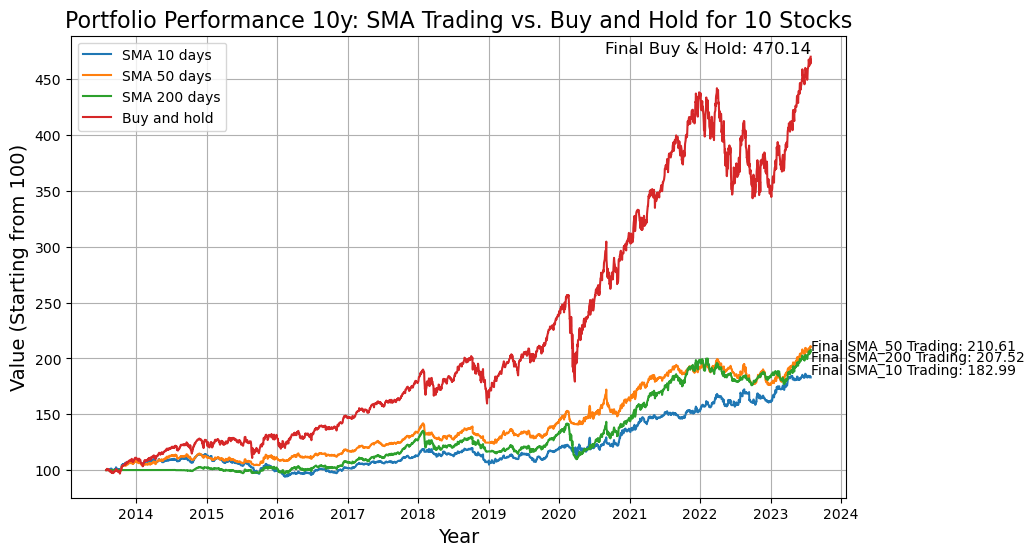

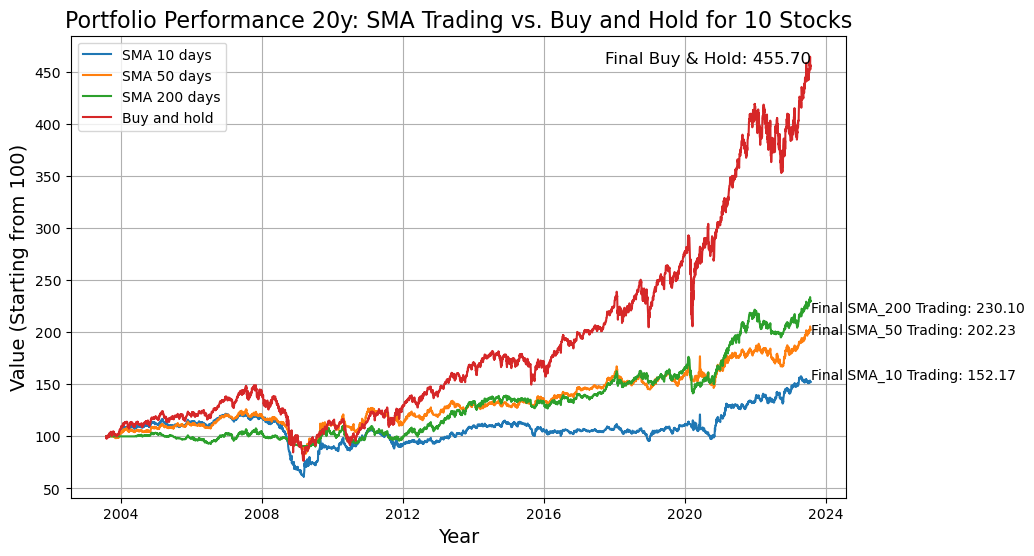

# Step 5. Draw conclusions
In both the 10-year and 20-year period, the plots show similar patterns. During bullish market behavior, the portfolio value steadily increased, though at a lower rate. Suprisingly, the SMA stategy demonstrated a degree of resilience during abrupt downward spikes, such as the 2008 crash and the COVID-19 pandemic. However, the SMA 10-day stgrategy experienced a significant decline of nearly 50%  lost close to 50% during the 2008 crisis. Furthermore, all three SMAs period seem to behave similarly.


In the long run, higher SMA periods yielded more profit than shorter ones. As shown in the second chart, the 10-day, 50-day, and 200-day SMA strategies finished with a 52.17%, 102.23%, and 130.1% profit respectively. Despite these gains, the buy-and-hold strategy significantly outperfomed the SMA strategies ending the 2003-2023 period with a 355.7% increase in value.

For the 20-year period, the buy-and-hold strategy held a 225.6 percentage points difference to the closest SMA strategy. This difference widened to 259.53 for the 10-year period.

In summary, the data shows the buy-and-hold strategy consistently outperformed the Simple Moving Average strategy for all three periods(10-day, 50-day, and 200-day).

**Lorenzo Zamel** 8/1/2023